# Xopt Parallel Examples

Xopt provides methods to parallelize optimizations using Processes, Threads, MPI, and Dask using the `concurrent.futures` interface as defined in  https://www.python.org/dev/peps/pep-3148/ .

In [1]:
# Import the class
from xopt import Xopt

# Notebook printing output
#from xopt import output_notebook
#output_notebook()

import multiprocessing
N_CPUS=multiprocessing.cpu_count()
N_CPUS

import os

# directory for data. 
os.makedirs("temp", exist_ok=True)


The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [2]:
# Make a proper input file.
YAML = """
xopt:
  asynch: True
  max_evaluations: 1000

generator:
  name: cnsga
  output_path: temp
  population_size:  64
  
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    sleep: 0
    random_sleep: 0.1
  
vocs:
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  linked_variables: {x9: x1}
  constants: {a: dummy_constant}

"""
X = Xopt(YAML)
X


            Xopt
________________________________
Version: 0.5.0+252.gced4dd5.dirty
Data size: 0
Config as YAML:
xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0.1, raise_probability: 0}
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constants: {a: dummy_constant}
  linked_variables: {x9: x1}


In [3]:
%%timeit
# Check that the average time is close to random_sleep
X.evaluator.function({"x1": 0.5, "x2": 0.5}, random_sleep = .1)

98.1 ms ± 20 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
%%time
X.run()

CPU times: user 8.91 s, sys: 94.9 ms, total: 9.01 s
Wall time: 1min 57s


# Processes

In [5]:
from concurrent.futures import ProcessPoolExecutor

In [6]:
%%time
X = Xopt(YAML)

with ProcessPoolExecutor() as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    
len(X.data)

CPU times: user 4.13 ms, sys: 5.15 ms, total: 9.28 ms
Wall time: 8.57 ms


0

# Threads

Continue running, this time with threads.

In [7]:
from concurrent.futures import ThreadPoolExecutor

In [8]:
%%time

X = Xopt(YAML)

with ThreadPoolExecutor() as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    X.run()
len(X.data)

CPU times: user 2.63 s, sys: 71.4 ms, total: 2.71 s
Wall time: 11.6 s


1002

# MPI 

The `test.yaml` file completely defines the problem. We will also direct the logging to an `xopt.log` file. The following invocation recruits 4 MPI workers to solve this problem.

We can also continue by calling `.save` with a JSON filename. This will write all of previous results into the file.

In [9]:
X = Xopt(YAML)
X.yaml('test.yaml')
!cat test.yaml

xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0.1, raise_probability: 0}
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constants: {a: dummy_constant}
  linked_variables: {x9: x1}


In [10]:
%%time
!mpirun -n {N_CPUS} python -m mpi4py.futures -m xopt.mpi.run -vv --logfile xopt.log test.yaml

Namespace(input_file='test.yaml', logfile='xopt.log', verbose=2)
Parallel execution with 10 workers
Initializing Xopt object
Initializing generator cnsga,
Created toolbox with 2 variables, 2 constraints, and 2 objectives.
    Using selection algorithm: nsga2
Initializing Xopt object
Xopt object initialized
Enabling async mode

            Xopt
________________________________
Version: 0.5.0+252.gced4dd5.dirty
Data size: 0
Config as YAML:
xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0.1, raise_probability: 0}
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  c

In [11]:
!tail xopt.log

2022-07-01T21:52:14-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T21:52:14-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T21:52:14-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T21:52:14-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T21:52:14-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T21:52:14-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T21:52:14-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T21:52:14-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T21:52:14-0700 - xopt.base - INFO - Running Xopt step
2022-07-01T21:52:14-0700 - xopt.base - INFO - Xopt is done. Max evaluations 1000 reached.


# Dask



In [12]:
from dask.distributed import Client
client = Client()
executor = client.get_executor()
client

2022-07-01 21:52:16,476 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/docs/examples/basic/dask-worker-space/worker-7e34hnsq', purging
2022-07-01 21:52:16,476 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/docs/examples/basic/dask-worker-space/worker-ya7sfuk6', purging
2022-07-01 21:52:16,476 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/docs/examples/basic/dask-worker-space/worker-amndv89x', purging
2022-07-01 21:52:16,476 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/docs/examples/basic/dask-worker-space/worker-_3a3p3w0', purging
2022-07-01 21:52:16,476 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/docs/examples/basic/dask-worker-space/worker-wqeymo0w', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61859,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:61892,Total threads: 2
Dashboard: http://127.0.0.1:61893/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:61866,


In [13]:
%%time
X = Xopt(YAML)
X.evaluator.executor = executor
X.evaluator.max_workers = N_CPUS
X.run()

CPU times: user 3.94 s, sys: 560 ms, total: 4.5 s
Wall time: 13.7 s


# Load output into Pandas

This algorithm writes two types of files: `gen_{i}.json` with all of the new individuals evaluated in a generation, and `pop_{i}.json` with the latest best population. Xopt provides some functions to load these easily into a Pandas dataframe for further analysis.

In [14]:
import pandas as pd

In [15]:
X.data

,x1,x2,a,x9,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str
9,0.153505,2.301854,dummy_constant,0.153505,0.153505,2.301854,4.273683,3.366736,"[1, 2, 3]",False,
2,0.292045,2.048320,dummy_constant,0.292045,0.292045,2.048320,3.344959,2.440541,"[1, 2, 3]",False,
3,0.895394,2.677982,dummy_constant,0.895394,0.895394,2.677982,6.929792,4.899941,"[1, 2, 3]",False,
10,2.627465,0.833314,dummy_constant,2.627465,2.627465,0.833314,6.577966,4.637205,"[1, 2, 3]",False,
8,2.515753,2.652315,dummy_constant,2.515753,2.515753,2.652315,12.272589,8.695720,"[1, 2, 3]",False,
...,...,...,...,...,...,...,...,...,...,...,...
995,0.519293,1.177117,dummy_constant,NaN,0.519293,1.177117,0.561837,0.458860,"[1, 2, 3]",False,
992,0.970713,0.312828,dummy_constant,NaN,0.970713,0.312828,0.012920,0.256604,"[1, 2, 3]",False,
1005,1.032230,0.780958,dummy_constant,NaN,1.032230,0.780958,0.734506,0.362206,"[1, 2, 3]",False,
1003,0.467793,0.506476,dummy_constant,NaN,0.467793,0.506476,-0.605162,0.001079,"[1, 2, 3]",False,


In [16]:
df = pd.concat([X.data, X.vocs.feasibility_data(X.data)], axis=1)
df[df['feasible']]

,x1,x2,a,x9,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str,feasible_c1,feasible_c2,feasible
28,1.032230,0.169421,dummy_constant,1.032230,1.032230,0.169421,0.180040,0.392551,"[1, 2, 3]",False,,True,True,True
49,1.107207,0.279165,dummy_constant,1.107207,1.107207,0.279165,0.372777,0.417469,"[1, 2, 3]",False,,True,True,True
67,0.899385,0.928903,dummy_constant,0.899385,0.899385,0.928903,0.575073,0.343467,"[1, 2, 3]",False,,True,True,True
72,1.040175,0.261173,dummy_constant,1.040175,1.040175,0.261173,0.220245,0.348827,"[1, 2, 3]",False,,True,True,True
69,0.970074,0.999472,dummy_constant,0.970074,0.970074,0.999472,0.842825,0.470441,"[1, 2, 3]",False,,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,0.849025,0.891498,dummy_constant,NaN,0.849025,0.891498,0.423136,0.275089,"[1, 2, 3]",False,,True,True,True
995,0.519293,1.177117,dummy_constant,NaN,0.519293,1.177117,0.561837,0.458860,"[1, 2, 3]",False,,True,True,True
992,0.970713,0.312828,dummy_constant,NaN,0.970713,0.312828,0.012920,0.256604,"[1, 2, 3]",False,,True,True,True
1005,1.032230,0.780958,dummy_constant,NaN,1.032230,0.780958,0.734506,0.362206,"[1, 2, 3]",False,,True,True,True


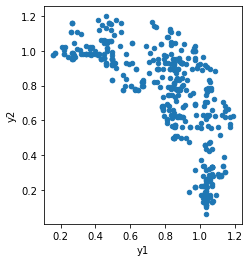

In [17]:
# Plot the feasible ones
feasible_df = df[df["feasible"]]
feasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

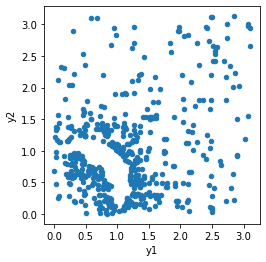

In [18]:
# Plot the infeasible ones
infeasible_df = df[~df["feasible"]]
infeasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

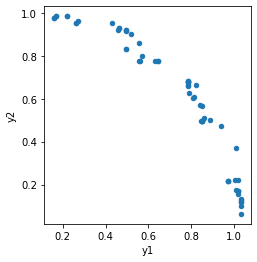

In [19]:
# This is the final population
df1 = X.generator.population
df1.plot("y1", "y2", kind="scatter").set_aspect("equal")

# matplotlib plotting

You can always use matplotlib for customizable plotting

In [20]:
import matplotlib.pyplot as plt

%matplotlib inline

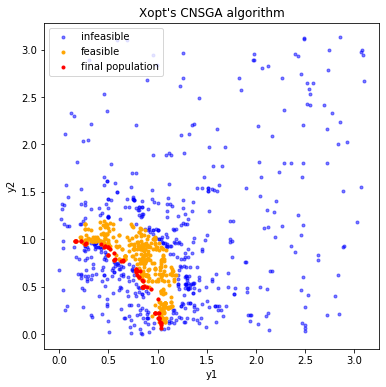

In [21]:
# Extract objectives from output
k1, k2 = "y1", "y2"

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    infeasible_df[k1],
    infeasible_df[k2],
    color="blue",
    marker=".",
    alpha=0.5,
    label="infeasible",
)
ax.scatter(
    feasible_df[k1], feasible_df[k2], color="orange", marker=".", label="feasible"
)
ax.scatter(df1[k1], df1[k2], color="red", marker=".", label="final population")
ax.set_xlabel(k1)
ax.set_ylabel(k2)
ax.set_aspect("auto")
ax.set_title(f"Xopt's CNSGA algorithm")
plt.legend()

In [22]:
# Cleanup
!rm -r dask-worker-space
!rm -r temp
!rm xopt.log*
!rm test.yaml